In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.figure_factory as ff
from scipy import ndimage
import pyproj

In [170]:
bav = pd.read_csv("../../data/processed/stops_with_data.csv")
# delet cols
bav.drop(columns=[
    "x_fa2", 
    "y_fa2",
    "indegree",
    "outdegree",
    "degree",
    "betweenness_centrality",
], inplace=True)
bav.rename(columns={
    "x_geo": "x",
    "y_geo": "y",
}, inplace=True)
bav.head()

,id,label,x,y,transport_type,city,canton,is_bus_stop,is_tram_stop,is_train_stop,is_metro_stop,is_rack_railway_stop,is_boat_stop
0,8500010,Basel SBB,8747.787053,1083.724166,Train,Basel,BS,False,False,True,False,False,False
1,8500016,Basel St. Johann,8740.453774,1098.214087,Train,Basel,BS,False,False,True,False,False,False
2,8500020,Muttenz,8772.829603,1075.023376,Train,Muttenz,BL,False,False,True,False,False,False
3,8500021,Pratteln,8791.268213,1068.157330,Train,Pratteln,BL,False,False,True,False,False,False
4,8500023,Liestal,8808.760961,1044.015059,Train,Liestal,BL,False,False,True,False,False,False


In [171]:
class Heatmap:
    def __init__(
            self, 
            df, 
            resolution = 1000, 
            left_margin = 0, 
            right_margin = 0,
            top_margin = 0,
            bottom_margin = 0
            ):
        self.df = df
        self.resolution = resolution
        self.left_margin = left_margin
        self.right_margin = right_margin
        self.top_margin = top_margin
        self.bottom_margin = bottom_margin

        self.df = self.set_coordinates()

    def set_coordinates(self):
        min_x = self.df['x'].min()
        max_x = self.df['x'].max()
        min_y = self.df['y'].min()
        max_y = self.df['y'].max()

        lon_scale = self.resolution / (max_x - min_x)
        lat_scale = self.resolution / (max_y - min_y)
        scale = min(lat_scale, lon_scale)

        self.df['x_con'] = (self.df['x'] - min_x) * scale
        self.df['y_con'] = (self.df['y'] - min_y) * scale
        self.df['x_dis'] = self.df['x_con'].astype(int)
        self.df['y_dis'] = self.df['y_con'].astype(int)

        self.width = int((max_x - min_x) * scale)
        self.height = int((max_y - min_y) * scale)

        return self.df

    def get_df(self):
        return self.df
    
    def get_density_heatmap(self, radius=10):
        density = np.zeros((
            self.width + self.left_margin + self.right_margin + 1, 
            self.height + self.top_margin + self.bottom_margin + 1
        ))

        for _, row in self.df.iterrows():
            x = int(row['x_dis']) + self.left_margin
            y = int(row['y_dis']) + self.bottom_margin
            density[x, y] += 1

        # Apply a Gaussian filter to compute the densities
        density_filtered = ndimage.gaussian_filter(density, sigma=radius)

        return density_filtered
    
    def get_density_heatmap_for_transport_type(self, transport_type, radius=10):
        density = np.zeros((
            self.width + self.left_margin + self.right_margin + 1, 
            self.height + self.top_margin + self.bottom_margin + 1
        ))

        for _, row in self.df.iterrows():
            if row[f'is_{transport_type}_stop']:
                x = int(row['x_dis']) + self.left_margin
                y = int(row['y_dis']) + self.bottom_margin
                density[x, y] += 1

        # Apply a Gaussian filter to compute the densities
        density_filtered = ndimage.gaussian_filter(density, sigma=radius)

        return density_filtered
    
    def show_map(self):
        fig = go.Figure()

        fig.add_trace(go.Scattergl(
            x=self.df['x_con'],
            y=self.df['y_con'],
            mode='markers',
            marker=dict(size=5, color='rgba(0, 0, 255, 0.8)', line=dict(width=1, color='black')),
            text=self.df.label,  # This can be customized to display more information on hover
            hoverinfo='text'
        ))

        fig.update_layout(
            xaxis=dict(range=[-self.left_margin, self.width + self.right_margin], title='X', scaleanchor="y", scaleratio=1),
            yaxis=dict(range=[-self.bottom_margin, self.height + self.top_margin], title='Y', scaleanchor="x", scaleratio=1),
            title='Map of every transport stop in Switzerland',
            hovermode='closest',
            autosize=False,
            width=self.width / 2,
            height=self.height / 2,
        )

        fig.show()

    def show_heatmap(self, density):
        fig, ax = plt.subplots()
        dpi = 100
        fig.set_size_inches(self.width / dpi, self.height / dpi)
        ax.imshow(density, cmap='hot', interpolation='nearest')
        ax.axis('off')
        plt.show()

    def show_density_heatmap(self, radius=10):
        density = self.get_density_heatmap(radius)
        density = np.rot90(density)

        self.show_heatmap(density)

    def show_density_heatmap_for_transport_type(self, transport_type, radius=10):
        density = self.get_density_heatmap_for_transport_type(transport_type, radius)
        density = np.rot90(density)

        self.show_heatmap(density)

    def show_density_heatmap_for_all_transport_types(self, radius=10):
        transport_types = ['bus', 'tram', 'train', 'metro', 'rack_railway', 'boat']
        num_transport_types = len(transport_types)

        fig, axes = plt.subplots(nrows=1, ncols=num_transport_types, figsize=(4 * num_transport_types, 4))
        dpi = 100
        fig.set_size_inches(self.width / dpi, self.height / dpi)

        for i, transport_type in enumerate(transport_types):
            density = self.get_density_heatmap_for_transport_type(transport_type, radius)
            density = np.rot90(density)

            ax = axes[i]
            ax.imshow(density, cmap='hot', interpolation='nearest')
            ax.set_title(f"{transport_type.capitalize()}")
            ax.axis('off')

        plt.tight_layout()
        plt.show()


heatmap = Heatmap(
    bav, 
    resolution=2000, 
    left_margin=20, 
    right_margin=50,
    top_margin=10,
    bottom_margin=0
    )

In [172]:
heatmap.show_map()

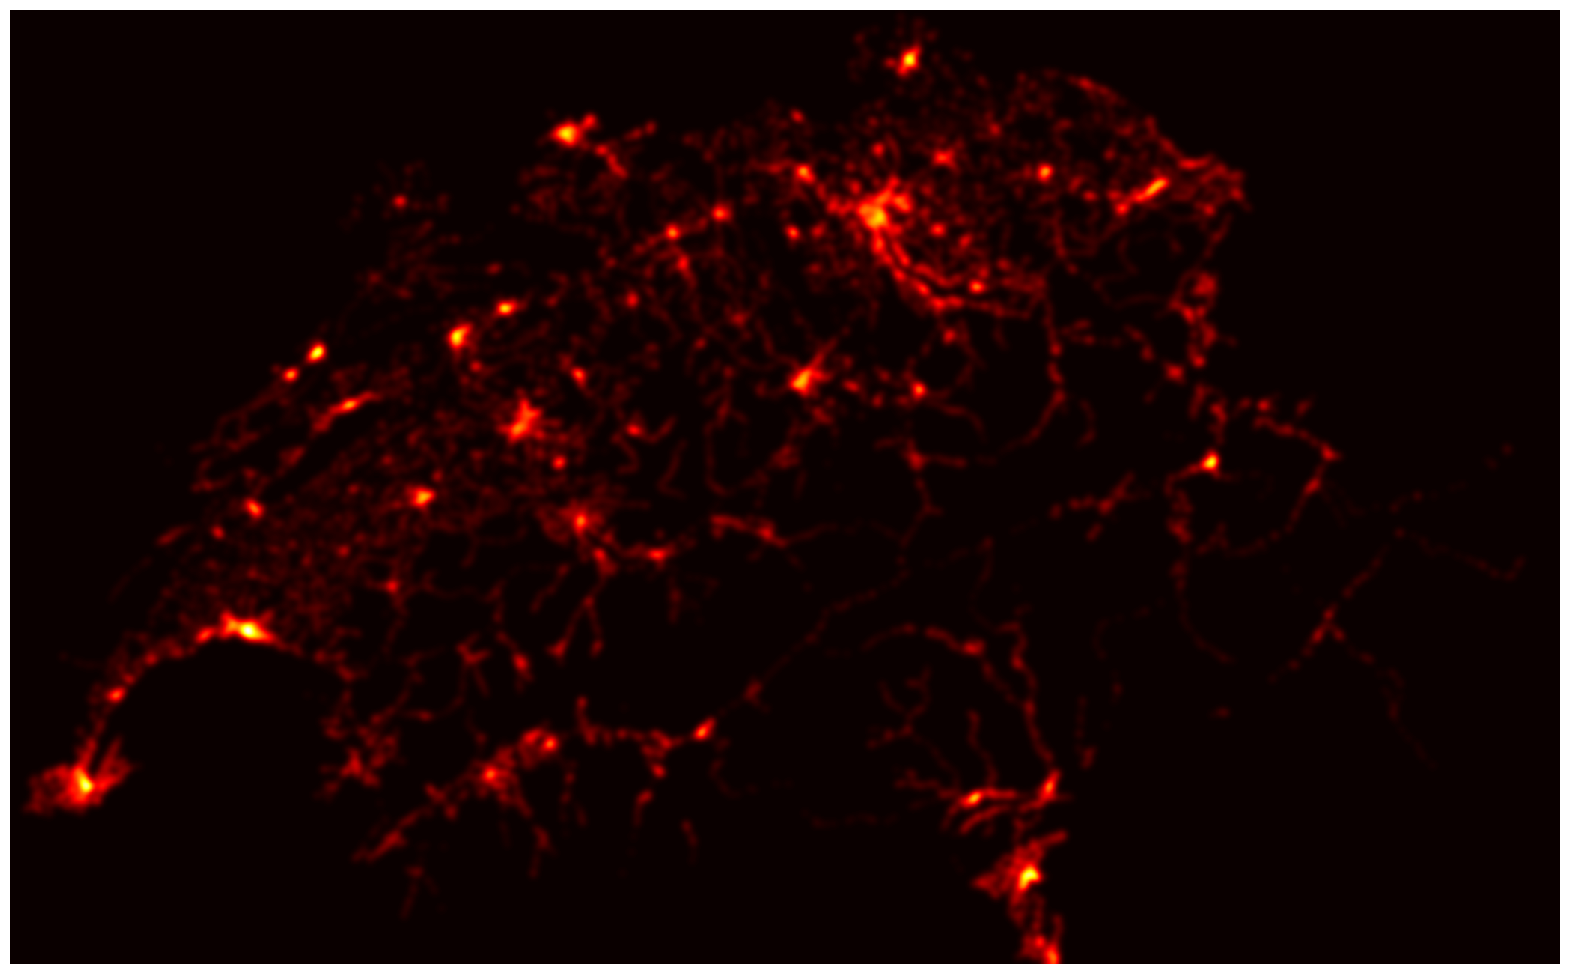

In [173]:
heatmap.show_density_heatmap(radius=5)

In [174]:
density_hm = heatmap.get_density_heatmap(radius=5)
density_hm = np.rot90(density_hm)

In [175]:
plt.imsave("../../data/processed/density_heatmap.png", density_hm, cmap='gray')

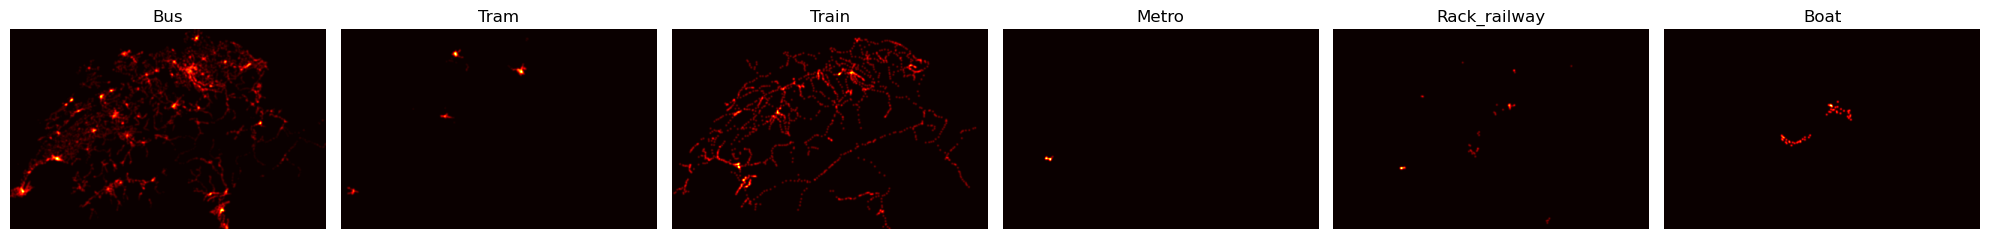

In [74]:
heatmap.show_density_heatmap_for_all_transport_types(radius=5)

## Threshold Heatmap

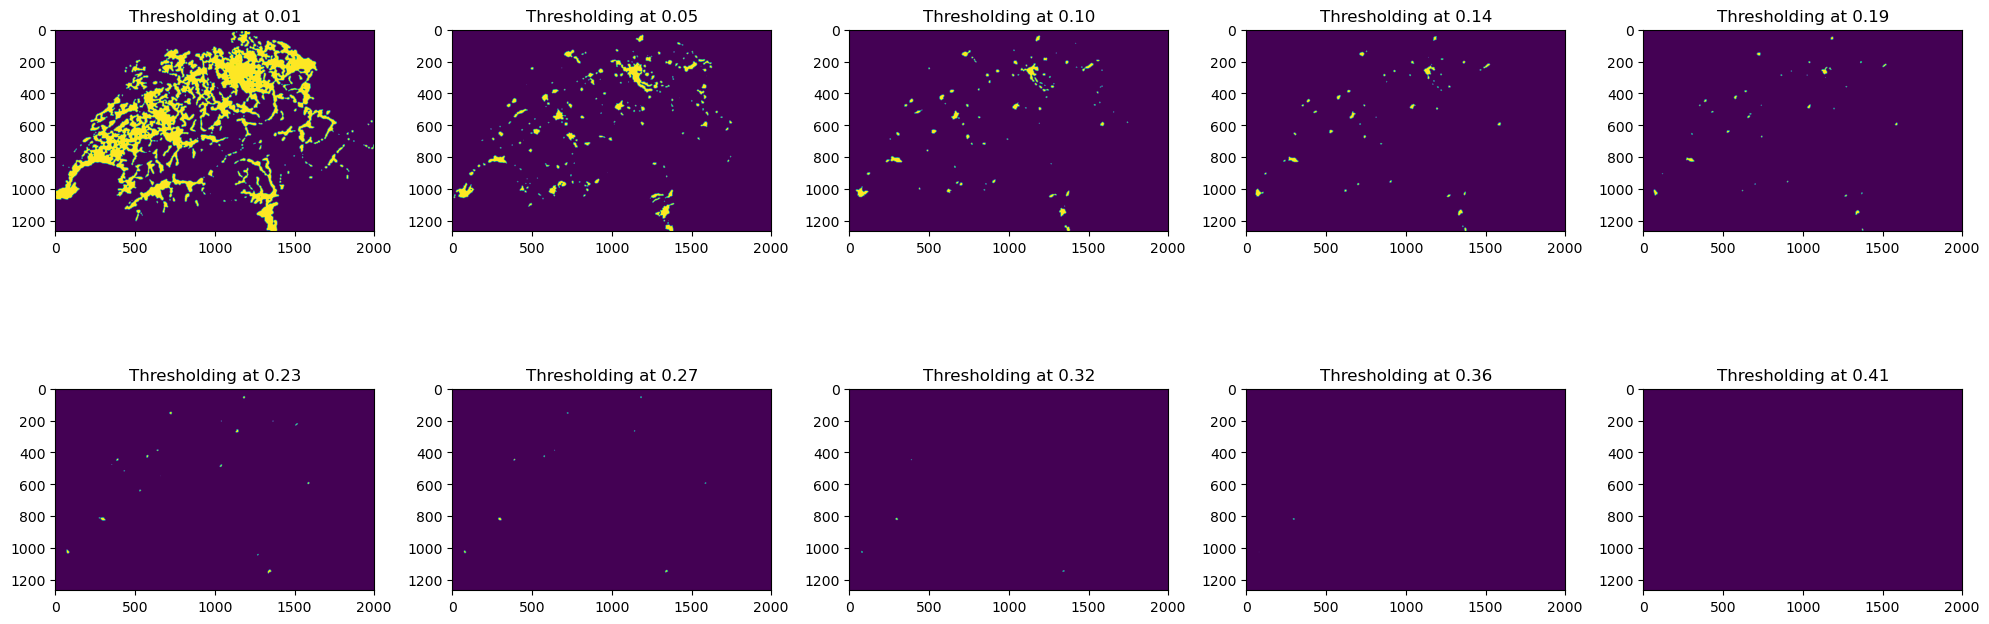

In [75]:
min_density_value = density_hm.min() + 0.01
max_density_value = density_hm.max()
n_steps = 10
# Get linearly spaced values between min and max
values = np.linspace(min_density_value, max_density_value, n_steps)

# Determine the dimensions of the subplot grid
rows = 2
cols = int(np.ceil(n_steps / rows))

# Create a figure and the subplot grid
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

for i, value in enumerate(values):
    density_hm_thded = density_hm > value
    ax = axs[i // cols, i % cols]  # Get the current axes in the subplot grid
    ax.imshow(density_hm_thded)
    ax.set_title(f"Thresholding at {value:.2f}")

    # save the thresholded heatmap
    plt.imsave(f"../../data/processed/density_heatmap_{i}.png", density_hm_thded, cmap='gray')

# Hide unused subplots if the number of plots is not equal to rows * cols
for i in range(n_steps, rows * cols):
    axs[i // cols, i % cols].axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

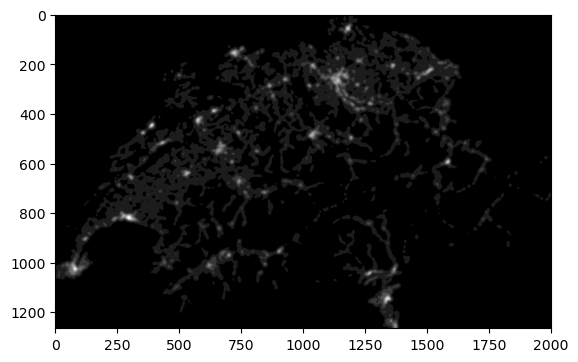

In [76]:
# Merge them together in a single image
min_density_value = density_hm.min() + 0.01
max_density_value = density_hm.max()
n_steps = 10
values = np.linspace(min_density_value, max_density_value, n_steps)

# Initialize a blank image with the same dimensions as the density heatmap
final_image = np.zeros_like(density_hm, dtype=np.float32)

# Iterate through each threshold value
for value in values:
    # Create a binary mask with 1s where the density heatmap is above the threshold
    mask = (density_hm > value).astype(np.float32)
    # Add the current mask to the final image, setting the intensity to the current threshold value
    final_image += mask

# Normalize the final image by dividing by the sum of all threshold values
final_image /= values.sum()

# Plot the final image
plt.imshow(final_image, cmap='gray')
plt.show()